# Image Registration Notebook 
For 3D images

README and dataset available on: https://github.com/ldelaoa/ImageRegistration_Tutorials

Dataset:https://grand-challenge.org/forums/forum/learn2reg-registration-challenge-449/topic/l2r23-data-release-1486/
Dataset:https://cloud.imi.uni-luebeck.de/s/L5Z3j7WzqCkADAb

In [1]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
from rigid_registration import tailor_registration
import registration_gui as rgui

In [2]:
#Version >2 is necessary
print("SimpleITK Version:", sitk.Version())

SimpleITK Version: SimpleITK Version: 2.2.1 (ITK 5.3)
Compiled: Dec  2 2022 12:26:06



Check Sizes
Check Orientation
Check Pixel Range Values

In [3]:
def normalizeSimpleITK(image,tresh_min,tresh_max):
    #image = sitk.Threshold(image, lower=tresh_min, upper=tresh_max)

    image_np = sitk.GetArrayFromImage(image)

    image_normalized = (image_np - (-1024)) / (600 - (-1024))
    
    image_normalized[image_normalized<=0]=0
    image_normalized[image_normalized>1]=1

    return image_normalized

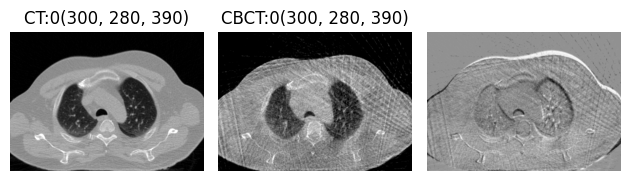

CT Values:  1.0 0.014778325
CBCT Values:  1.0 0.0


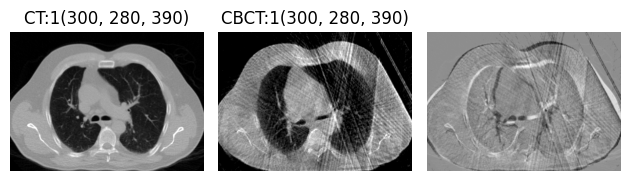

CT Values:  1.0 0.014778325
CBCT Values:  1.0 0.0


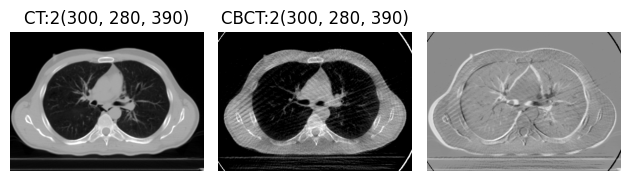

CT Values:  1.0 0.014778325
CBCT Values:  1.0 0.0


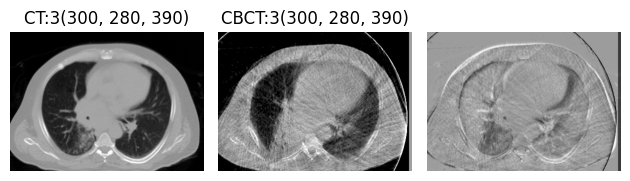

CT Values:  1.0 0.014778325
CBCT Values:  1.0 0.0


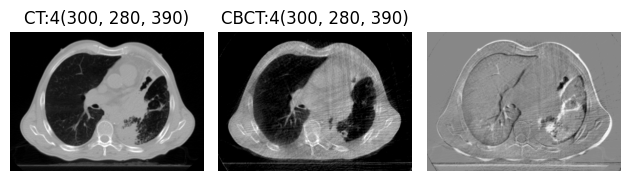

CT Values:  1.0 0.014778325
CBCT Values:  1.0 0.0


In [4]:
root = "C:/Users/delaoArevaLR/OneDrive - UMCG/Backup/Desktop/CBCT-CT_SampleData/ThoraxCBCT/imagesTr/"
name = "ThoraxCBCT_000"
for i in range(5):
    ct_path = root+name+str(i)+"_0000.nii.gz"
    image_sitk = sitk.ReadImage(ct_path, sitk.sitkFloat32)
    image_array_ct = normalizeSimpleITK(image_sitk,-1024,600)
    plt.subplot(1,3,1),plt.imshow(image_array_ct[150,:,:],cmap="gray"),plt.axis('off')
    plt.title("CT:"+str(i)+str(image_array_ct.shape))
    
    cbct_path= root+name+str(i)+"_0001.nii.gz"
    image_sitk = sitk.ReadImage(cbct_path, sitk.sitkFloat32)
    image_array_cbct = normalizeSimpleITK(image_sitk,-1024,600)
    plt.subplot(1,3,2),plt.imshow(image_array_cbct[150,:,:],cmap="gray"),plt.axis('off')
    plt.title("CBCT:"+str(i)+str(image_array_cbct.shape))
    
    plt.subplot(1,3,3),plt.imshow(image_array_ct[150,:,:]-image_array_cbct[150,:,:],cmap="gray"),plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("CT Values: ",image_array_ct.max(),image_array_ct.min())
    print("CBCT Values: ",image_array_cbct.max(),image_array_cbct.min())

For this notebook we assume Square 1 is the fixed image

Choose a moving image and load them as SimpleITK image

In [5]:
#Select
fixed_image_path = "ThoraxCBCT_0000_0000.nii.gz"
moving_image_path = "ThoraxCBCT_0000_0001.nii.gz"

#Load
fixed_image = sitk.ReadImage(root+fixed_image_path, sitk.sitkFloat32)
moving_image = sitk.ReadImage(root+moving_image_path, sitk.sitkFloat32)
#To Normalized array
fixed_array = normalizeSimpleITK(fixed_image,-1024,600)
moving_array = normalizeSimpleITK(moving_image,-1024,600)

Image dimensions: Fixed Image:  (300, 280, 390)  Moving Image: (300, 280, 390)


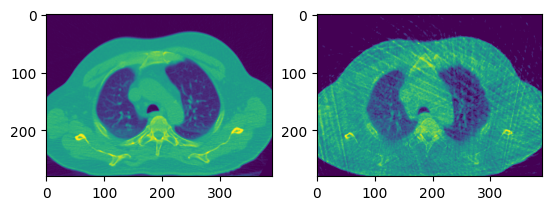

In [6]:
#Visualize both of your images, notice the difference between them
print("Image dimensions: Fixed Image: ",fixed_array.shape," Moving Image:", moving_array.shape)
plt.subplot(121),plt.imshow(fixed_array[140,:,:])
plt.subplot(122),plt.imshow(moving_array[140,:,:])
plt.show()

### Possible Transform values are:  
-- **2D Transforms:** Euler2D. Similarity2D. ScaleTransform2D. Translation2D.  
-- **Center Spec:** Geometry . Moments.  
-- **Metrics:** Correlation . MatesMutualInformation. MeanSquares.  
-- **Optimizer:** GradientDescent . RegularStepGradientDescent.  
-- **Shift:** IndexShift . PhysicalShift

### Other configurations editable with current defaults:  
**For TranslationTransform:** offset="Diff" or "Fix" or "Mov".
"Diff" is difference between centroids of moving and target. "Fixed" is centroid of Fixed. "Mov" is centroid of Moving.  

**For Optimizers** : .   
iterations_spec=300  . Maximum number of iteration for all Optimizers.  
lr=1  Learning Rate for all Optimizers.  
minStep=.00001  , Minimum Step for Optimizer: Regular Step Gradient Descent.  
gradientT=1e-7  , GradientMagnitudeTolerance for Optimizer :  Regular Step Gradient Descent.  
convWinSize=10  , Convergence Minimum Value for Optimizer: Gradient Descent.  
convMinVal=1e-7 , Convergence Window Size for Optimizer: : Gradient Descent.  

In [ ]:
transf_spec = "Scale3D" #"Similarity3D" "VersorRigid3D" "Scale3D"
center_spec = "Moments"  # Geometry or Moments
metric_spec = "MatesMutualInformation"  # "Correlation" or "MatesMutualInformation" or "MeanSquares"
optimizer = "RegularStepGradientDescent"  # GradientDescent" or "RegularStepGradientDescent"
shift_sepc = "PhysicalShift"  # "PhysicalShift" or "IndexShift"

#Both Optimizers
iterations_spec=300
lr=2
#ResgularStep Gradient 
minStep=1e-6
gradientT=1e-7
#Gradient Descent
convMinVal =1
convWinSize = int(1e-18)

#Offset
offset = "Fix" #Fix, Mov, Diff

#Plot results
plot_boolean=False

moved_array, evaluationMetric, final_transform = tailor_registration(fixed_array, moving_array, transf_spec,
                                                                         center_spec, metric_spec, optimizer,
                                                                         shift_sepc, offset, iterations_spec=iterations_spec,
                                                                         lr=lr,minStep=minStep, gradientT=gradientT,
                                                                         convMinVal=convMinVal,convWinSize = convWinSize,plot_bool=plot_boolean)

Image dimensions: Image:  (300, 280, 390)  Image 2: (300, 280, 390)


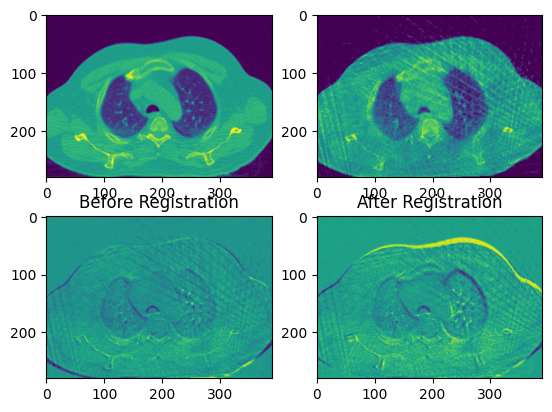

In [12]:
#Visually see the registration: 
print("Image dimensions: Image: ",fixed_array.shape," Image 2:", moved_array.shape)
plt.subplot(221),plt.imshow(fixed_array[150,:,:])
plt.subplot(222),plt.imshow(moved_array[150,:,:])
plt.subplot(223),plt.imshow(fixed_array[150,:,:]-moved_array[150,:,:]),plt.title("Before Registration")
plt.subplot(224),plt.imshow(fixed_array[150,:,:]-moving_array[150,:,:]),plt.title("After Registration")
plt.show()

In [9]:
print(np.sum(fixed_array)/np.sum(moved_array))

print(np.sum(fixed_array)/np.sum(moving_array))

0.9618577
0.9314241
